# It was a failed attempt, but very meaningful to me, to train and save a state dictionary of generators and discriminators with a symbolic dataset, and to try to define new model instances of generators and discriminators and load the dictionary, by which I wanted to create a work of art that would be completely satisfying to myself, but unfortunately I failed.

In [6]:
pip install opencv-python


     --------------------------------------- 38.2/38.2 MB 26.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import cv2


In [12]:
import os
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
data_dir = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/Symbolism_Resized" 

image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(data_dir, transform=tt.Compose([
  tt.Resize(image_size),
  tt.CenterCrop(image_size),
  tt.ToTensor(),
  tt.Normalize(*stats)
]))
indeces = random.sample([x for x in range(len(train_ds))],1510)
train_ds_subset = Subset(train_ds,indeces)

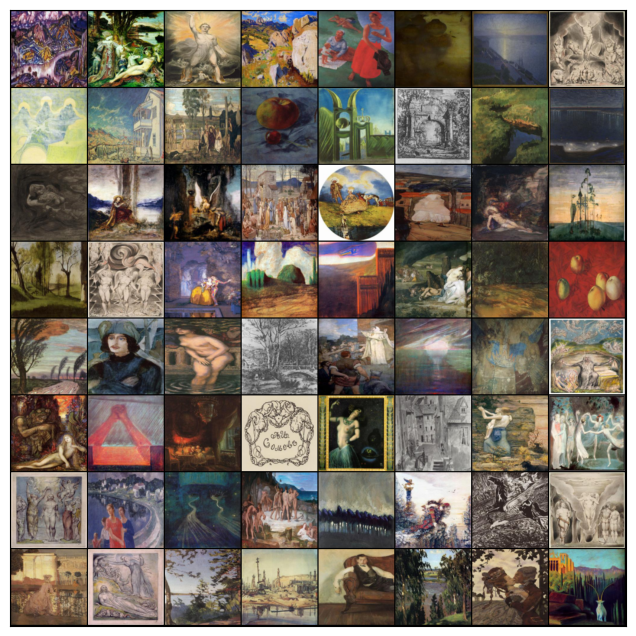

In [13]:
train_dl = DataLoader(train_ds_subset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
from torchvision.utils import make_grid
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):  
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    imga = make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0)
    ax.imshow(imga)
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(train_dl)

In [14]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

import torch
device = get_default_device()

print(device)
train_dl = DeviceDataLoader(train_dl, device)

cpu


In [15]:
class Generator(nn.Module):  
    def __init__(self, a, latent):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
         
          nn.ConvTranspose2d(latent, a[4], kernel_size=4, stride=1, padding=0, bias=False),
          nn.BatchNorm2d(a[4]),
          nn.ReLU(True),
         
          nn.ConvTranspose2d(a[4], a[3], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[3]),
          nn.ReLU(True),
         
          nn.ConvTranspose2d(a[3], a[2], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[2]),
          nn.ReLU(True),      
       
          nn.ConvTranspose2d(a[2], a[1], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[1]),
          nn.ReLU(True),
        
          nn.ConvTranspose2d(a[1], a[0], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[0]),
          nn.ReLU(True),
        
          nn.ConvTranspose2d(a[0], 3, kernel_size=4, stride=2, padding=1, bias=False),
          nn.Tanh()
      
        )

    def forward(self, input):
        return self.main(input)
    
    
    
class Discriminator(nn.Module):
    def __init__(self, a):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
        
          nn.Conv2d(3, a[0], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[0]),
          nn.LeakyReLU(0.2, inplace=True),
         
          nn.Conv2d(a[0], a[1], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[1]),
          nn.LeakyReLU(0.2, inplace=True),
        
          nn.Conv2d(a[1], a[2], kernel_size=4, stride=1, padding=2, bias=False),
          nn.BatchNorm2d(a[2]),
          nn.LeakyReLU(0.2, inplace=True),
        
          nn.Conv2d(a[2], a[3], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[3]),
          nn.LeakyReLU(0.2, inplace=True),
     
          nn.Conv2d(a[3], a[4], kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(a[4]),
          nn.LeakyReLU(0.2, inplace=True),    

          nn.Conv2d(a[4], 1, kernel_size=8, stride=1, padding=0, bias=False),

          nn.Flatten(),
          nn.Sigmoid()
          )

    def forward(self, input):
        return self.main(input)


latent_size = 256
lay = [64,128,256,512,1024]
generator = to_device(Generator(lay, latent_size), device)
discriminator = to_device(Discriminator(lay), device)

In [17]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU可用')
else:
    device = torch.device('cpu')
    print('GPU不可用，使用CPU')

x = torch.tensor([1, 2, 3]).to(device)

y = x * 2

print(y.to('cpu'))

GPU不可用，使用CPU
tensor([2, 4, 6])


In [20]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [21]:
def train_discriminator(real_images, opt_d):

  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()
  
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)
 
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  #REGULAR GAN: binary_cross_entropy   , mse_loss
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score



def train_generator(opt_g):
 
    opt_g.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
   
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
   
    loss.backward()
    opt_g.step()
    return loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


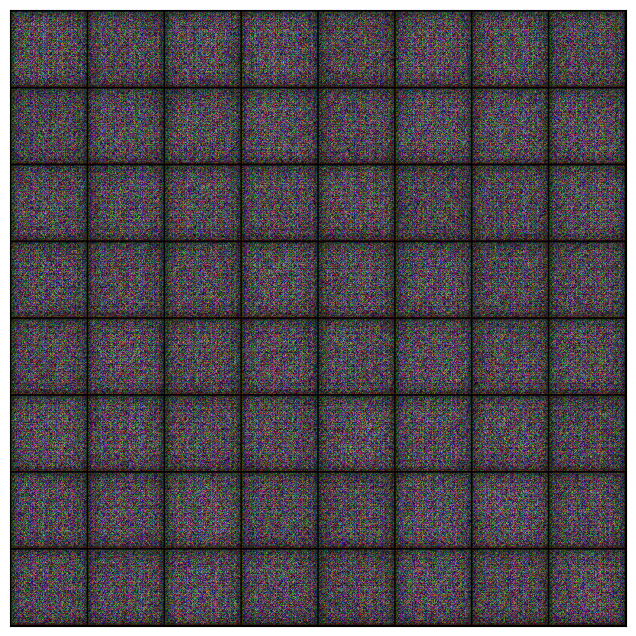

In [22]:

sample_dir = './images/'
os.makedirs(sample_dir, exist_ok=True)
gd_dir = './network/'
os.makedirs(gd_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  
save_samples(0, fixed_latent)

In [29]:

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr[0], betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr[1], betas=(0.5, 0.999))
    
    
    epoch_st = epochs[0]
    epoch_end = epochs[1]
    for epoch in range(epoch_st,epoch_end):
        
        if epoch%20==0:
            torch.save(generator.state_dict(), './network/G'+str(epoch)+'.pth')
            torch.save(discriminator.state_dict(), './network/D'+str(epoch)+'.pth')

        for real_images, _ in tqdm(train_dl):
          
            if epoch%2==0:
                loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            else: loss_d = -1; real_score = -1; fake_score = -1; 
            
         
            loss_g = train_generator(opt_g)
            
    
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
 
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)
        
lr = [4.5e-4,1e-4] 

epoch_st = 0; epoch_end = 50
epochs = [epoch_st,epoch_end]
losses_g = []; losses_d = []; real_scores = []; fake_scores = []
fit(epochs, lr)

torch.save(generator.state_dict(), "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict.pth")
torch.save(discriminator.state_dict(), "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict2.pth")

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [1/[0, 50]], loss_g: 4.8818, loss_d: 1.0407, real_score: 0.9912, fake_score: 0.5585
Saving generated-images-0001.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [2/[0, 50]], loss_g: 0.0167, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0002.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [3/[0, 50]], loss_g: 3.1834, loss_d: 0.5724, real_score: 0.7647, fake_score: 0.2190
Saving generated-images-0003.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [4/[0, 50]], loss_g: 0.0205, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0004.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [5/[0, 50]], loss_g: 3.0349, loss_d: 0.5089, real_score: 0.7211, fake_score: 0.1397
Saving generated-images-0005.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [6/[0, 50]], loss_g: 0.0169, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0006.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [7/[0, 50]], loss_g: 3.5575, loss_d: 0.3988, real_score: 0.8287, fake_score: 0.1733
Saving generated-images-0007.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [8/[0, 50]], loss_g: 0.0164, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0008.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [9/[0, 50]], loss_g: 2.5979, loss_d: 0.4832, real_score: 0.7441, fake_score: 0.1443
Saving generated-images-0009.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [10/[0, 50]], loss_g: 0.0314, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0010.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [11/[0, 50]], loss_g: 3.2087, loss_d: 0.4453, real_score: 0.7940, fake_score: 0.1572
Saving generated-images-0011.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [12/[0, 50]], loss_g: 0.0239, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0012.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [13/[0, 50]], loss_g: 3.2143, loss_d: 0.5096, real_score: 0.8518, fake_score: 0.2659
Saving generated-images-0013.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [14/[0, 50]], loss_g: 0.0313, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0014.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [15/[0, 50]], loss_g: 3.1155, loss_d: 0.4076, real_score: 0.8235, fake_score: 0.1656
Saving generated-images-0015.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [16/[0, 50]], loss_g: 0.0354, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0016.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [17/[0, 50]], loss_g: 4.2816, loss_d: 0.6506, real_score: 0.8553, fake_score: 0.3643
Saving generated-images-0017.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [18/[0, 50]], loss_g: 0.0500, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0018.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [19/[0, 50]], loss_g: 3.6005, loss_d: 0.3503, real_score: 0.8845, fake_score: 0.1860
Saving generated-images-0019.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [20/[0, 50]], loss_g: 0.0230, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0020.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [21/[0, 50]], loss_g: 3.5771, loss_d: 0.5421, real_score: 0.7649, fake_score: 0.2142
Saving generated-images-0021.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [22/[0, 50]], loss_g: 0.0193, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0022.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [23/[0, 50]], loss_g: 3.1718, loss_d: 0.5694, real_score: 0.7987, fake_score: 0.2523
Saving generated-images-0023.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [24/[0, 50]], loss_g: 0.0175, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0024.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [25/[0, 50]], loss_g: 2.8835, loss_d: 0.3411, real_score: 0.8159, fake_score: 0.1152
Saving generated-images-0025.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [26/[0, 50]], loss_g: 0.0214, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0026.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [27/[0, 50]], loss_g: 3.4750, loss_d: 0.4977, real_score: 0.8746, fake_score: 0.2752
Saving generated-images-0027.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [28/[0, 50]], loss_g: 0.0301, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0028.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [29/[0, 50]], loss_g: 3.3030, loss_d: 0.4760, real_score: 0.8303, fake_score: 0.2187
Saving generated-images-0029.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [30/[0, 50]], loss_g: 0.0382, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0030.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [31/[0, 50]], loss_g: 3.7660, loss_d: 0.4319, real_score: 0.8572, fake_score: 0.2201
Saving generated-images-0031.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [32/[0, 50]], loss_g: 0.0353, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0032.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [33/[0, 50]], loss_g: 4.2406, loss_d: 0.5749, real_score: 0.8648, fake_score: 0.3117
Saving generated-images-0033.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [34/[0, 50]], loss_g: 0.0241, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0034.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [35/[0, 50]], loss_g: 3.1483, loss_d: 0.4316, real_score: 0.8385, fake_score: 0.1989
Saving generated-images-0035.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [36/[0, 50]], loss_g: 0.0267, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0036.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [37/[0, 50]], loss_g: 3.0445, loss_d: 0.4838, real_score: 0.7308, fake_score: 0.1277
Saving generated-images-0037.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [38/[0, 50]], loss_g: 0.0218, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0038.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [39/[0, 50]], loss_g: 2.3416, loss_d: 0.4120, real_score: 0.7612, fake_score: 0.0943
Saving generated-images-0039.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [40/[0, 50]], loss_g: 0.0247, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0040.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [41/[0, 50]], loss_g: 2.1526, loss_d: 0.5718, real_score: 0.7041, fake_score: 0.1204
Saving generated-images-0041.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [42/[0, 50]], loss_g: 0.0385, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0042.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [43/[0, 50]], loss_g: 3.2017, loss_d: 0.4567, real_score: 0.8089, fake_score: 0.1930
Saving generated-images-0043.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [44/[0, 50]], loss_g: 0.0199, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0044.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [45/[0, 50]], loss_g: 3.6479, loss_d: 0.3765, real_score: 0.8591, fake_score: 0.1841
Saving generated-images-0045.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [46/[0, 50]], loss_g: 0.0207, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0046.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [47/[0, 50]], loss_g: 3.5949, loss_d: 0.3464, real_score: 0.9153, fake_score: 0.2085
Saving generated-images-0047.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [48/[0, 50]], loss_g: 0.0265, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0048.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [49/[0, 50]], loss_g: 3.3918, loss_d: 0.5111, real_score: 0.8070, fake_score: 0.2279
Saving generated-images-0049.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [50/[0, 50]], loss_g: 0.0355, loss_d: -1.0000, real_score: -1.0000, fake_score: -1.0000
Saving generated-images-0050.png


In [43]:
#save info to local computer  (need to click link!)
%cd "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter"
from IPython.display import FileLink 
#!zip -r -j /kaggle/working/network.zip /kaggle/working/network

C:\Users\ASUS\miniconda3\envs\coding3\etc\jupyter


In [45]:
#save generator, discriminator manually
FileLink("C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict.pth")

C:\Users\ASUS\miniconda3\envs\coding3\etc\jupyter\model_state_dict.pth

In [52]:
import zipfile

folder_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/Symbolism_Resized"
zip_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/Symbolism_Resized.zip"

with zipfile.ZipFile(zip_path, "w") as zip_file:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            zip_file.write(file_path, os.path.basename(file_path))


In [53]:
FileLink(r'Symbolism_Resized.zip')

C:\Users\ASUS\miniconda3\envs\coding3\etc\jupyter\Symbolism_Resized.zip

In [54]:
import numpy as np
dd = np.array([losses_g, losses_d, real_scores, fake_scores])
np.savetxt('data.csv',dd,delimiter=';')
FileLink(r'data.csv')

C:\Users\ASUS\miniconda3\envs\coding3\etc\jupyter\data.csv

In [55]:
#load in model if so wanted
'''generator = Generator(lay, latent_size)
generator.load_state_dict(torch.load("C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict.pth", map_location=device ))
generator.train()
discriminator = Discriminator(lay)
discriminator.load_state_dict(torch.load("C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict2.pth", map_location=device ))
discriminator.train()
'''

'generator = Generator(lay, latent_size)\ngenerator.load_state_dict(torch.load("C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict.pth", map_location=device ))\ngenerator.train()\ndiscriminator = Discriminator(lay)\ndiscriminator.load_state_dict(torch.load("C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict2.pth", map_location=device ))\ndiscriminator.train()\n'

In [70]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [75]:
# 设置训练参数
lr = 0.001
beta1 = 0.5
epochs = 30

# 设置文件路径
dataset_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/archive"
generator_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict.pth"
discriminator_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/model_state_dict2.pth"
output_path = "output.gif"


In [84]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [85]:
batch = next(iter(dataloader))

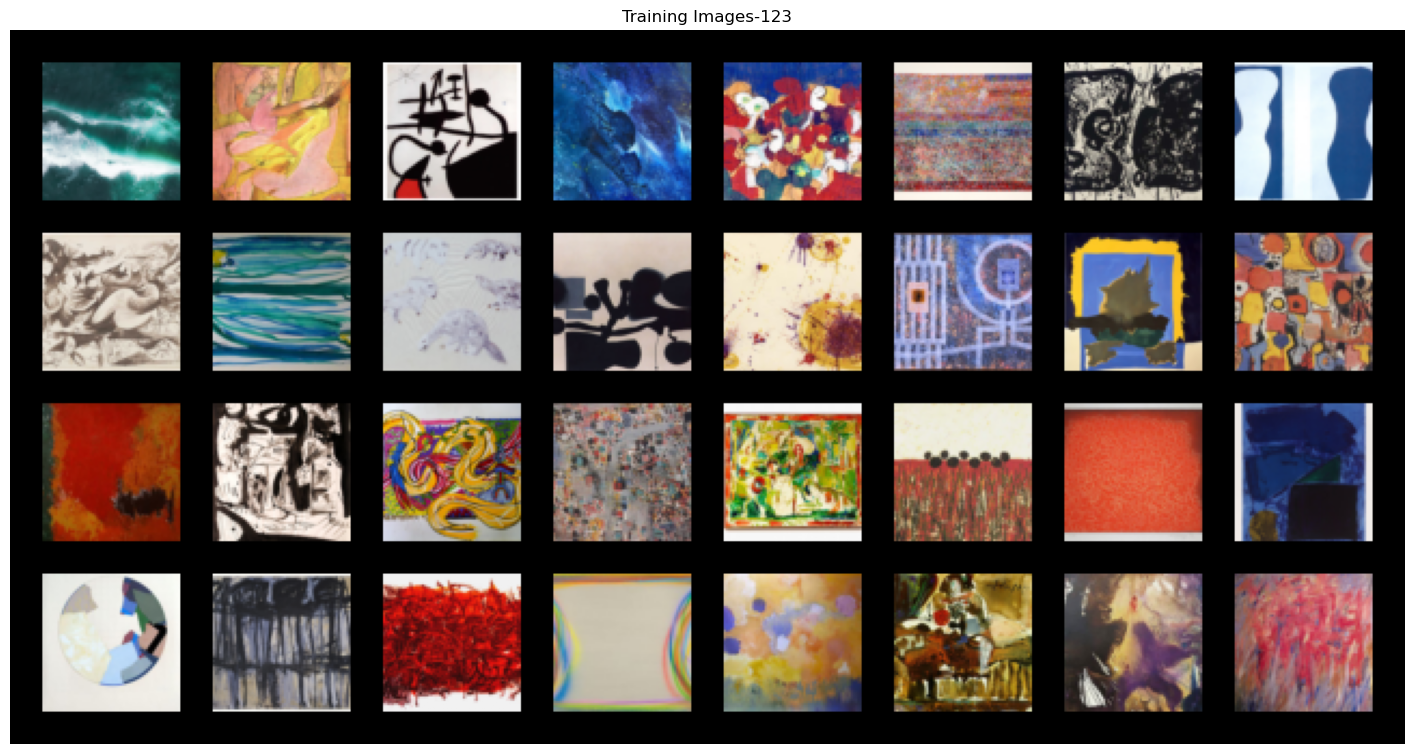

In [96]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images-123")

# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=15, normalize=True, nrow=8).cpu(),(1,2,0)))

In [129]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [130]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [131]:
generator = Generator()  # 根据生成器的结构定义生成器实例
generator.load_state_dict(torch.load(generator_path, map_location=device))

discriminator = Discriminator()  # 根据判别器的结构定义判别器实例
discriminator.load_state_dict(torch.load(discriminator_path, map_location=device))


RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "conv2.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "conv3.weight", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "conv4.weight", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "conv5.weight". 
	Unexpected key(s) in state_dict: "main.0.weight", "main.1.weight", "main.1.bias", "main.1.running_mean", "main.1.running_var", "main.1.num_batches_tracked", "main.3.weight", "main.4.weight", "main.4.bias", "main.4.running_mean", "main.4.running_var", "main.4.num_batches_tracked", "main.6.weight", "main.7.weight", "main.7.bias", "main.7.running_mean", "main.7.running_var", "main.7.num_batches_tracked", "main.9.weight", "main.10.weight", "main.10.bias", "main.10.running_mean", "main.10.running_var", "main.10.num_batches_tracked", "main.12.weight", "main.13.weight", "main.13.bias", "main.13.running_mean", "main.13.running_var", "main.13.num_batches_tracked", "main.15.weight". 